# Reproduction of FACS results using segmentation and colocalization of the images

This script is meant to analyse 2D confocal images from Schumacher 2023 figures 4G and H

Import packages, load segmentation model and define input and output paths

In [1]:
import tilesegment.tools.tools as tools
import tilesegment.tools.tiling as tiling
import matplotlib.pyplot as plt

from embdevtools import get_file_embcode, read_img_with_resolution, CellTracking, load_CellTracking, save_4Dstack
from embdevtools.celltrack.core.tools.tools import get_outlines_masks_labels
import numpy as np


### LOAD STARDIST MODEL ###
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

### PATH TO YOU DATA FOLDER AND TO YOUR SAVING FOLDER ###
path_data='/home/pablo/Desktop/PhD/projects/Data/belas/2D/Sina/activin/crops/movies/'
path_save='/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/'


2023-11-22 16:44:11.628626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 16:44:12.695011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-11-22 16:44:13.665761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Define an activin quantity and load images. Activin concentration must be on the format like this `100ng` or `6.25ng` in order to be correctly read.

In [2]:
concentration = "50ng"

### GET FULL FILE NAME AND FILE CODE ###
file, embcode, files = get_file_embcode(path_data, "_"+concentration, allow_file_fragment=True, returnfiles=True)

### LOAD HYPERSTACKS ###
IMGS, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=0)
IMG = IMGS[0,0]

IMGS_cer1, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=1)
IMG_cer1 = IMGS_cer1[0,0]

IMGS_oct4, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=2)
IMG_oct4 = IMGS_oct4[0,0]

IMGS_otx2, xyres, zres = read_img_with_resolution(path_data+file, stack=False, channel=3)
IMG_otx2 = IMGS_otx2[0,0]

try: 
    xyresdif = np.abs(np.abs(xyres[0]) - np.abs(xyres[1]))
    print("xyres dif =", xyresdif)
    xyres = np.mean(xyres)
except: 
    pass

print(xyres)

0.36044530855199747


Define tiling information: 

* `Ts` = Tile size
* `D` = Image size after squaring the image and making int multiple of Ts
* `O` = Overlap based on cell nuclei. For example 3 times the mean cell nuclei as observed using the remove debrie script
* `Tso` = Tile size with overlap
* `DO` = total image size with overlap
* `n` = number of tiles in a row or column
* `N` = total number of tiles

In [3]:
### TILING ###

# Tile size
Ts = 1024
# Size with overlap
O = np.rint(27.5*3).astype('int16') #got using GMM on diameters of an example segmentation
tile_info = tiling.generate_tiling_info(IMG, Ts, O)

Generate padded image

In [4]:
# Create squared and padded image
IMG_padded, pad_info = tiling.pad_image_and_square_array(IMG, tile_info)

Define a threshold diameter for debris removal

In [5]:
diam_th = 5 #microns

Loop over tiles rows (`i`) and columns (`j`). Once segmentation is completed, cells falling into the overlaping area must be removed. That what `mins` and `maxs` are used for. Also, `offset` must be computed so that `center`, `outline` and `mask` have indexes corresponding to the whole image, not the tile. 

In [6]:
centers, outlines, masks, diameters = tiling.tile_segment(IMG_padded, 
                                                model, 
                                                tile_info, 
                                                pad_info, 
                                                xyres, 
                                                diam_th, 
                                                verbose=True)
### SEGMENTATION COMPLETED ###

1/1 [==============================] - 1s 832ms/step
tiles left = 48
1/1 [==============================] - 1s 579ms/step
tiles left = 47
1/1 [==============================] - 1s 556ms/step
tiles left = 46
1/1 [==============================] - 1s 557ms/step
tiles left = 45
1/1 [==============================] - 1s 546ms/step
tiles left = 44
1/1 [==============================] - 1s 556ms/step
tiles left = 43
1/1 [==============================] - 1s 549ms/step
tiles left = 42
1/1 [==============================] - 1s 551ms/step
tiles left = 41
1/1 [==============================] - 1s 546ms/step
tiles left = 40
1/1 [==============================] - 1s 546ms/step
tiles left = 39
1/1 [==============================] - 1s 547ms/step
tiles left = 38
1/1 [==============================] - 1s 542ms/step
tiles left = 37
1/1 [==============================] - 1s 536ms/step
tiles left = 36
1/1 [==============================] - 1s 538ms/step
tiles left = 35
1/1 [=============================

Once the segmentation is completed, we can compute colocalization of the different markers with the segmented masks. We can compute the sum ot the mean within a mask. I trust more the results using mean as it removes information about cell size. 

In [7]:
### COLOCALIZATION AND DENSITY PLOTS ###

cer1 = []
oct4 = []
otx2 = []
for mask in masks:
    mask[mask < 0] = 0
    mask[:,0][mask[:,0]>=IMG.shape[0]] = IMG.shape[0]-1
    mask[:,1][mask[:,1]>=IMG.shape[1]] = IMG.shape[1]-1


    cer1.append(np.mean(IMG_cer1[mask[:,0], mask[:,1]]))
    oct4.append(np.mean(IMG_oct4[mask[:,0], mask[:,1]]))
    otx2.append(np.mean(IMG_otx2[mask[:,0], mask[:,1]]))


In [8]:
print(len(masks))

30271


Once we have the values for the fluorescence per cell we can show some cells as examples of what to expect for each of the cases

In [81]:
### PLOT 3 CELL MARKERS AND MASK ###
import random 
x = ['cer1', 'otx2', 'oct4']
r = 20


c1 = random.randint(0, len(centers)-1)
c1 = 18746
center = np.rint(centers[c1]).astype("int32")
mask = masks[c1]
outline = outlines[c1]
outline = tools.increase_point_resolution(outline, 100)
IMG_mask = np.zeros_like(IMG)
IMG_mask[mask[:,0], mask[:,1]] = 1


fig ,ax = plt.subplots(2,6, figsize=(25,8), gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios': [1,1]}, dpi=600)
# fig.suptitle("activin = %s" %concentration)
ax[0,0].imshow(IMG, vmin=0, vmax=255)
ax[0,0].set_title("hoechst", fontsize=15)
ax[0,0].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,0].set_xlim(center[1]-r,center[1]+r)
ax[0,0].set_ylim( center[0]-r,center[0]+r)
ax[0,0].grid(False)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

ax[0,1].imshow(IMG_mask, vmin=0, vmax=1)
ax[0,1].set_title("mask", fontsize=15)
ax[0,1].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,1].set_xlim(center[1]-r,center[1]+r)
ax[0,1].set_ylim( center[0]-r,center[0]+r)
ax[0,1].grid(False)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

ax[0,2].imshow(IMG_cer1, vmin=0, vmax=255)
ax[0,2].set_title("cer1", fontsize=15)
ax[0,2].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,2].set_xlim(center[1]-r,center[1]+r)
ax[0,2].set_ylim( center[0]-r,center[0]+r)
ax[0,2].grid(False)
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])

ax[0,3].imshow(IMG_otx2, vmin=0, vmax=255)
ax[0,3].set_title("otx2", fontsize=15)
ax[0,3].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,3].set_xlim(center[1]-r,center[1]+r)
ax[0,3].set_ylim( center[0]-r,center[0]+r)
ax[0,3].grid(False)
ax[0,3].set_xticks([])
ax[0,3].set_yticks([])

ax[0,4].imshow(IMG_oct4, vmin=0, vmax=255)
ax[0,4].set_title("oct4", fontsize=15)
ax[0,4].scatter(outline[:,1], outline[:,0], c="C5")
ax[0,4].set_xlim(center[1]-r,center[1]+r)
ax[0,4].set_ylim( center[0]-r,center[0]+r)
ax[0,4].grid(False)
ax[0,4].set_xticks([])
ax[0,4].set_yticks([])

y1 = [cer1[c1], otx2[c1], oct4[c1]]

ax[0,5].bar(x, y1, color=["yellow", "magenta", "blue"])
ax[0,5].set_title("mean intensity within mask", fontsize=15)
ax[0,5].set_xticklabels(x, fontsize=12)


c2 = random.randint(0, len(centers)-1)
c2 = 13116
r = 20
center = np.rint(centers[c2]).astype("int32")
mask = masks[c2]
outline = outlines[c2]
outline = tools.increase_point_resolution(outline, 100)
IMG_mask = np.zeros_like(IMG)
IMG_mask[mask[:,0], mask[:,1]] = 1

ax[1,0].imshow(IMG, vmin=0, vmax=255)
ax[1,0].grid(False)
ax[1,0].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,0].set_xlim(center[1]-r,center[1]+r)
ax[1,0].set_ylim( center[0]-r,center[0]+r)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,1].imshow(IMG_mask, vmin=0, vmax=1)
ax[1,1].grid(False)
ax[1,1].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,1].set_xlim(center[1]-r,center[1]+r)
ax[1,1].set_ylim( center[0]-r,center[0]+r)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

ax[1,2].imshow(IMG_cer1, vmin=0, vmax=255)
ax[1,2].grid(False)
ax[1,2].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,2].set_xlim(center[1]-r,center[1]+r)
ax[1,2].set_ylim( center[0]-r,center[0]+r)
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])

ax[1,3].imshow(IMG_otx2, vmin=0, vmax=255)
ax[1,3].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,3].set_xlim(center[1]-r,center[1]+r)
ax[1,3].set_ylim( center[0]-r,center[0]+r)
ax[1,3].grid(False)
ax[1,3].set_xticks([])
ax[1,3].set_yticks([])

ax[1,4].imshow(IMG_oct4, vmin=0, vmax=255)
ax[1,4].scatter(outline[:,1], outline[:,0], c="C5")
ax[1,4].set_xlim(center[1]-r,center[1]+r)
ax[1,4].set_ylim( center[0]-r,center[0]+r)
ax[1,4].grid(False)
ax[1,4].set_xticks([])
ax[1,4].set_yticks([])

y2 = [cer1[c2], otx2[c2], oct4[c2]]
ax[1,5].bar(x, y2, color=["yellow", "magenta", "blue"])
ax[1,5].set_xticklabels(x, fontsize=12)

max_yaxis = np.max([np.max(y1),np.max(y2)])
ax[0,5].set_ylim(0, max_yaxis*1.1)
ax[1,5].set_ylim(0, max_yaxis*1.1)

plt.tight_layout()


plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/coloc%s.png" %concentration, format='png')
plt.show()

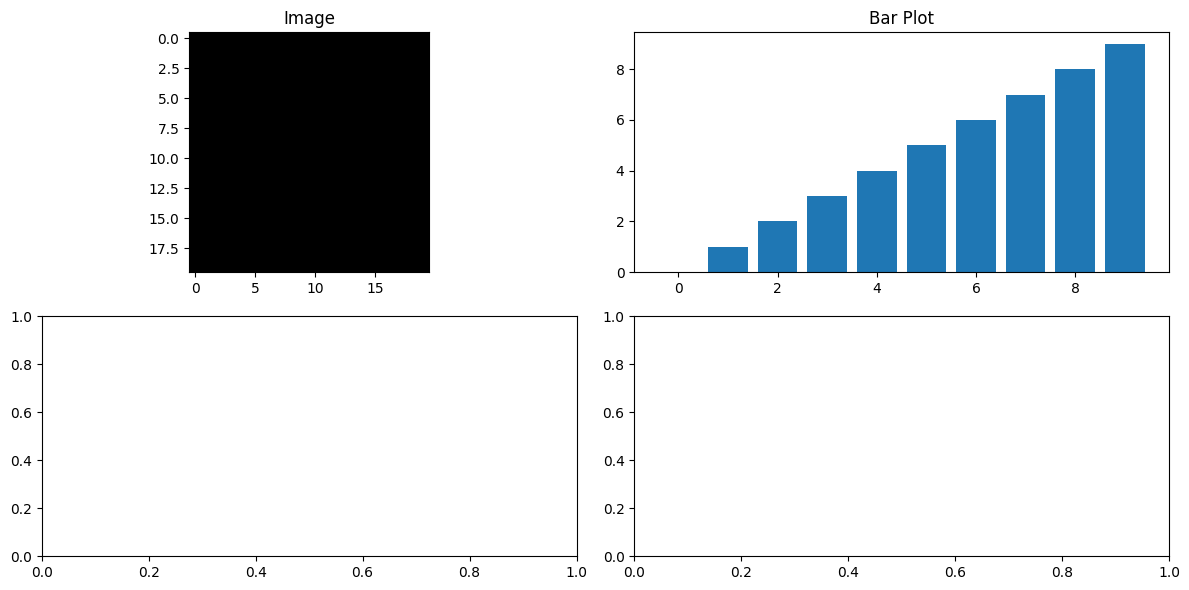

In [54]:

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Create a figure and a 2x6 grid
fig, ax = plt.subplots(2,2, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# Add the image to the first subplot
image_data = np.zeros((20,20))  # Your image data here
ax[0,0].imshow(image_data, cmap='gray')  # Adjust cmap based on your image type
ax[0,0].set_title('Image')

# Add the bar plot to the second subplot
bar_data = range(10)  # Your bar plot data here
ax[0,1].bar(range(len(bar_data)), bar_data)
ax[0,1].set_title('Bar Plot')

# If there are other subplots in the grid, you can adjust their properties as needed

# Adjust the layout to make subplots evenly spaced
plt.tight_layout()

# Show the plot
plt.show()

Now we can compute the cell point density as we would do with the FACS results and plot it using a normal scatter plot with weighted values. To note that I have used the stardar pyplot colormap as the usual colormaps used for FACS (`turbo`, `jet`) are proven to be more confusing (citation needed). 

In [ ]:
from scipy.stats import gaussian_kde

# Calculate the point density
otx2cer1 = np.vstack([np.log(otx2),np.log(cer1)])
z_otx2cer1 = gaussian_kde(otx2cer1)(otx2cer1)

oct4cer1 = np.vstack([np.log(oct4),np.log(cer1)])
z_oct4cer1 = gaussian_kde(oct4cer1)(oct4cer1)

otx2oct4 = np.vstack([np.log(otx2),np.log(oct4)])
z_otx2oct4 = gaussian_kde(otx2oct4)(otx2oct4)

Plot for `otx2` vs `cer1`

In [ ]:

fig, ax = plt.subplots(figsize=(7,7))
sc = ax.scatter(otx2, cer1, c=z_otx2cer1, s=1.0)
# plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(4, 10**2.45)
ax.set_ylim(1, 10**2.3)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("otx2", fontsize=20)
ax.set_ylabel("cer1", fontsize=20)
ax.set_title("activin "+concentration, fontsize=30)
plt.tight_layout()
plt.savefig(path_save+"otx2-cer1_activin-"+concentration+".png")
plt.show()

Plot for `oct4` vs `cer1`

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(oct4, cer1, c=z_oct4cer1, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(7, 10**2)
ax.set_ylim(2, 10**2.1)
ax.set_xlabel("oct4")
ax.set_ylabel("cer1")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig(path_save+"oct4-cer1_activin-"+concentration+".png")
plt.show()

Plot for `otx2` vs `oct4`

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(otx2, oct4, c=z_otx2oct4, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(5, 10**2.4)
ax.set_ylim(7, 10**2)
ax.set_xlabel("otx2")
ax.set_ylabel("oct4")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig(path_save+"otx2-oct4_activin-"+concentration+".png")
plt.show()

Plot cell diameter vs each of the markers

In [ ]:
areas = [len(mask) for mask in masks]
diameters2 = [2*np.sqrt(area/np.pi) for area in areas]

In [ ]:
# Calculate the point density

areas_oct4 = np.vstack([np.log(areas),np.log(oct4)])
z_areas_oct4 = gaussian_kde(areas_oct4)(areas_oct4)

areas_otx2 = np.vstack([np.log(areas),np.log(otx2)])
z_areas_otx2 = gaussian_kde(areas_otx2)(areas_otx2)

areas_cer1 = np.vstack([np.log(areas),np.log(cer1)])
z_areas_cer1 = gaussian_kde(areas_cer1)(areas_cer1)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))

sc = ax.scatter(areas, oct4, c=z_areas_oct4, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(130, 1100)
ax.set_ylim(7, 10**2)
ax.set_xlabel("area")
ax.set_ylabel("oct4")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/"+"areas-oct4_activin-"+concentration+".png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(areas, otx2, c=z_areas_otx2, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(130, 1100)
ax.set_ylim(5, 10**2.4)
ax.set_xlabel("area")
ax.set_ylabel("otx2")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/"+"areas-otx2_activin-"+concentration+".png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(areas, cer1, c=z_areas_cer1, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(130, 1100)
ax.set_ylim(2, 10**2.1)
ax.set_xlabel("area")
ax.set_ylabel("cer1")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/"+"areas-cer1_activin-"+concentration+".png")
plt.show()

Now the same but with max diameters

In [ ]:
# Calculate the point density

diams_oct4 = np.vstack([np.log(diameters1),np.log(oct4)])
z_diams_oct4 = gaussian_kde(diams_oct4)(diams_oct4)

diams_otx2 = np.vstack([np.log(diameters1),np.log(otx2)])
z_diams_otx2 = gaussian_kde(diams_otx2)(diams_otx2)

diams_cer1 = np.vstack([np.log(diameters1),np.log(cer1)])
z_diams_cer1 = gaussian_kde(diams_cer1)(diams_cer1)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))

sc = ax.scatter(diameters1, oct4, c=z_diams_oct4, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(15, 50)
ax.set_ylim(7, 10**2)
ax.set_xlabel("max diameter")
ax.set_ylabel("oct4")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/"+"diameters-oct4_activin-"+concentration+".png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(diameters1, otx2, c=z_diams_otx2, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(15, 50)
ax.set_ylim(5, 10**2.4)
ax.set_xlabel("max diameter")
ax.set_ylabel("otx2")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/"+"diameters-otx2_activin-"+concentration+".png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sc = ax.scatter(diameters1, cer1, c=z_diams_cer1, s=0.5)
plt.colorbar(sc, ax=ax, label='Number of points per pixel')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(15, 50)
ax.set_ylim(2, 10**2.1)
ax.set_xlabel("max diameter")
ax.set_ylabel("cer1")
ax.set_title("activin "+concentration)
plt.tight_layout()
plt.savefig("/home/pablo/Desktop/PhD/projects/AVEDifferentiation/results/2D/activin/"+"diameters-cer1_activin-"+concentration+".png")
plt.show()